## Tools

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Dataset

In [27]:
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
# data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/MLF/BreastCancerData.csv")
# data.head(10)

Dataset directly uploaded to google colab runtime disk and accessed

In [29]:
data = pd.read_csv("BreastCancerData.csv")
data.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


**Function for generating all-round results**

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, log_loss


def generate_results(y_test, y_pred, y_proba=None):

  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"Precision: {precision_score(y_test, y_pred)}")
  print(f"Recall: {recall_score(y_test, y_pred)}")
  print(f"F1 Score: {f1_score(y_test, y_pred)}")

  cm = confusion_matrix(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)

  print(f"\nAUC: {auc}")
  print(f"\nLog loss: {log_loss(y_test, y_pred)}\n")

  fpr, tpr, thresholds = roc_curve(y_test, y_proba if y_proba is not None else y_pred)

  fig, ax = plt.subplots(1, 2, figsize=(12, 6))

  ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[0])
  ax[0].set_title('Confusion Matrix')

  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
  roc_display.plot(ax=ax[1])
  ax[1].plot([0, 1], [0, 1], color='green', linestyle='--')
  ax[1].set_title('ROC Curve')

  plt.tight_layout()
  plt.show()

## Basic EDA

<Axes: >

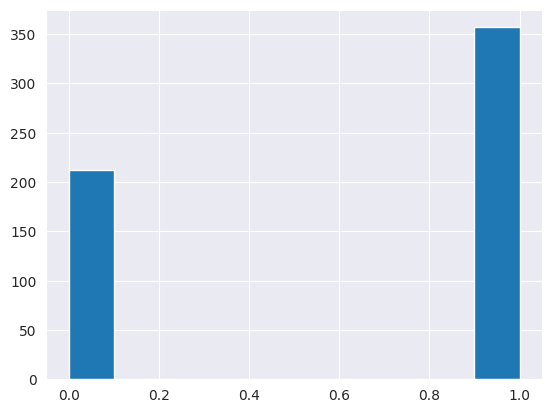

In [31]:
data["diagnosis"].hist()

<Axes: >

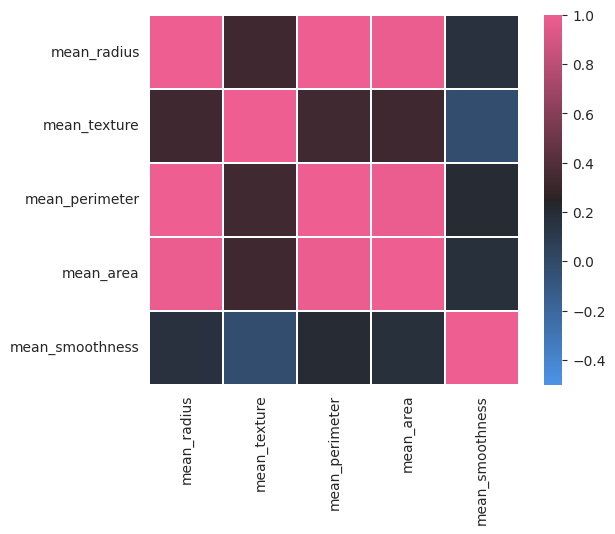

In [32]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [33]:
data = data[["mean_radius", "mean_texture", "mean_smoothness", "diagnosis"]]
data.head(10)

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
5,12.45,15.70,0.12780,0
6,18.25,19.98,0.09463,0
7,13.71,20.83,0.11890,0
8,13.00,21.82,0.12730,0
9,12.46,24.04,0.11860,0


<Axes: xlabel='mean_texture', ylabel='Count'>

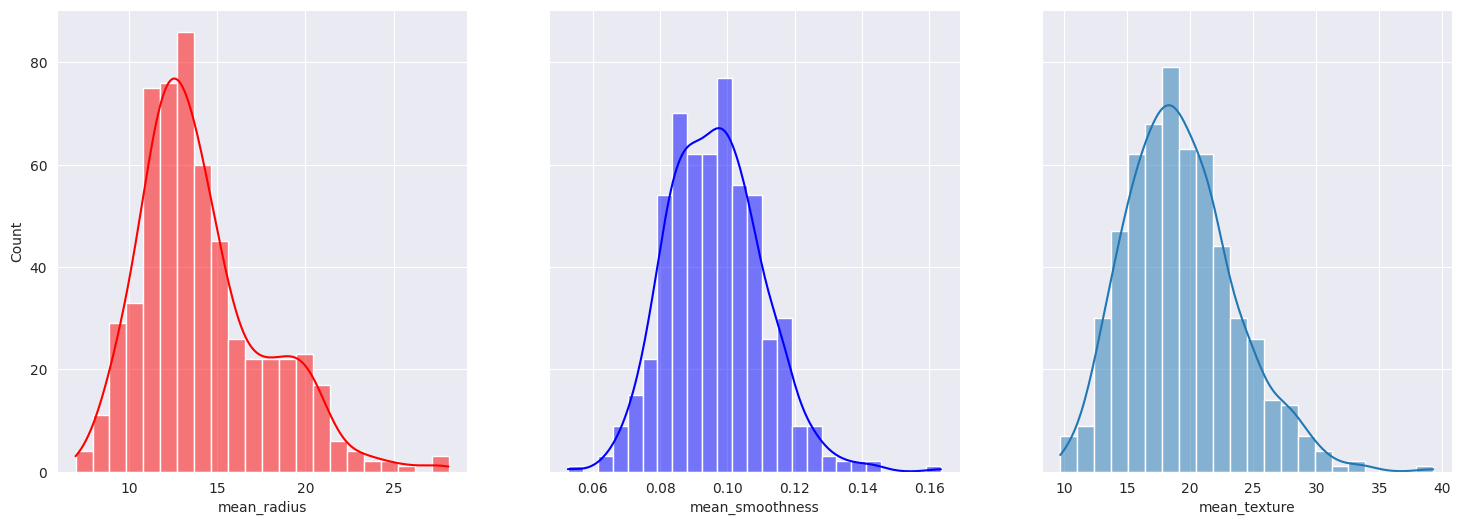

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)

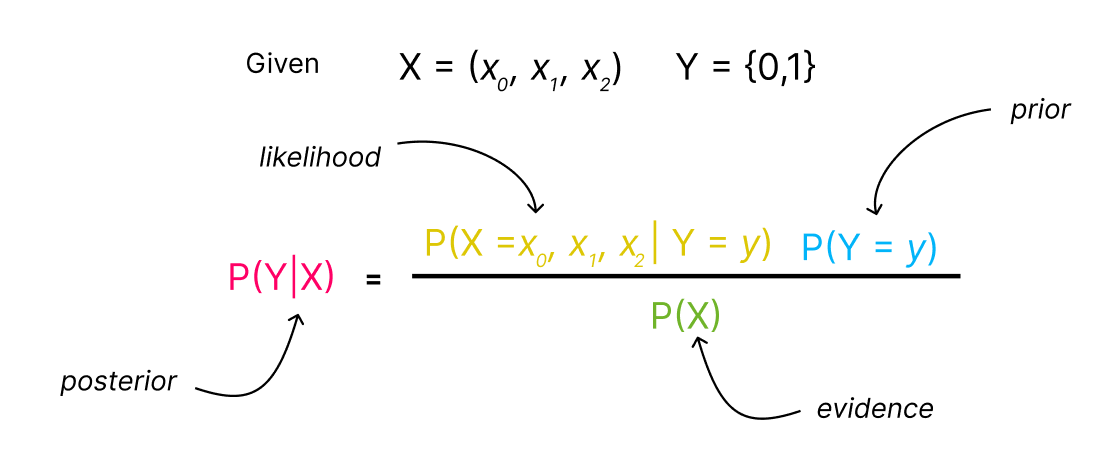

## Calculate P(Y=y) for all possible y

In [35]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [36]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [37]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

## Test Gaussian model

In [38]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158


what does means 0? false negative ... and what about 4? false positive

Accuracy: 0.9649122807017544
Precision: 0.9487179487179487
Recall: 1.0
F1 Score: 0.9736842105263158

AUC: 0.9500000000000001

Log loss: 1.2646895926006019



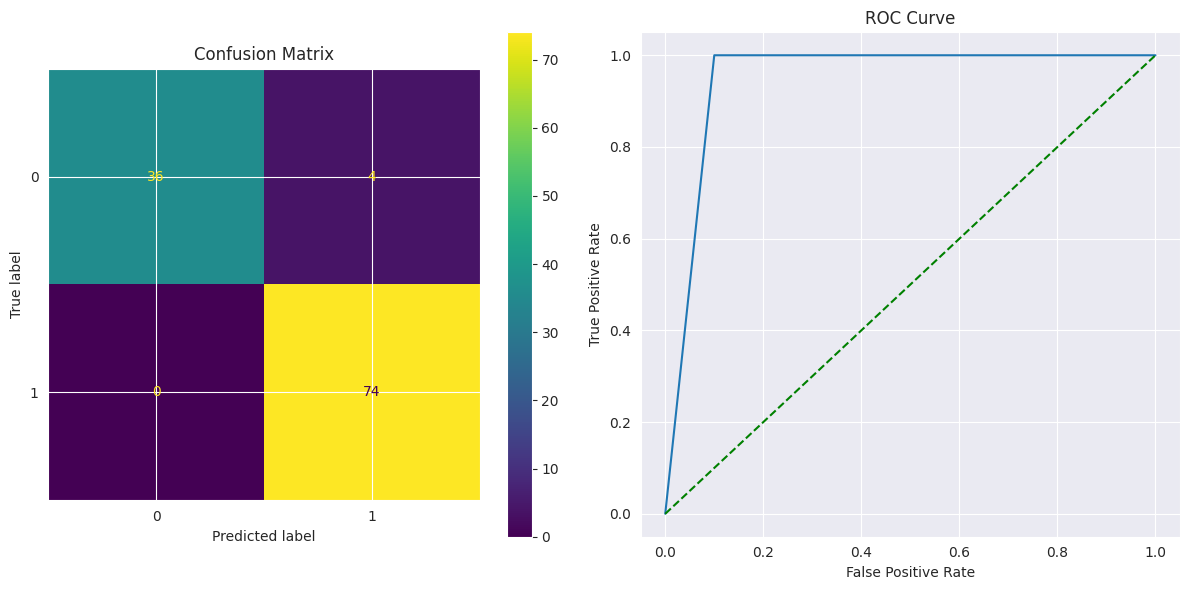

In [39]:
# all-round results
generate_results(Y_test, Y_pred)

## Convert continuous features to Categorical features

In [40]:
data_encoded = data.copy()
data_encoded["cat_mean_radius"] = pd.cut(data_encoded["mean_radius"].values, bins = 3, labels = [0,1,2])
data_encoded["cat_mean_texture"] = pd.cut(data_encoded["mean_texture"].values, bins = 3, labels = [0,1,2])
data_encoded["cat_mean_smoothness"] = pd.cut(data_encoded["mean_smoothness"].values, bins = 3, labels = [0,1,2])

data_encoded = data_encoded.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
data_encoded = data_encoded[["cat_mean_radius",	"cat_mean_texture",	"cat_mean_smoothness", "diagnosis"]]
data_encoded.head(10)

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0
5,0,0,2,0
6,1,1,1,0
7,0,1,1,0
8,0,1,2,0
9,0,1,1,0


## Approach 2: Calculate P(X=x|Y=y) categorically

In [41]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [42]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

## Test Categorical model

In [43]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_encoded, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[38  2]
 [ 5 69]]
0.9517241379310345


Accuracy: 0.9385964912280702
Precision: 0.971830985915493
Recall: 0.9324324324324325
F1 Score: 0.9517241379310345

AUC: 0.9412162162162161

Log loss: 2.2132067870510532



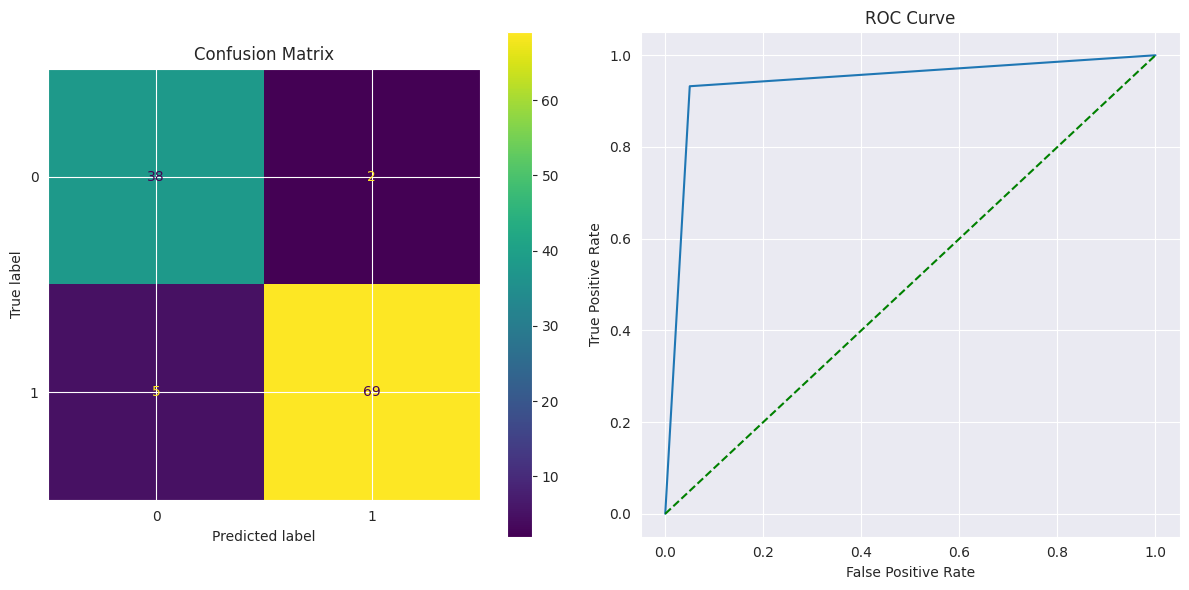

In [44]:
# all-round results
generate_results(Y_test, Y_pred)

---

**Comparision with Scikit-learn library implementations**

Gaussian Naive Bayes with sklearn library

Accuracy: 0.9649122807017544
Precision: 0.9487179487179487
Recall: 1.0
F1 Score: 0.9736842105263158

AUC: 0.9500000000000001

Log loss: 1.2646895926006019



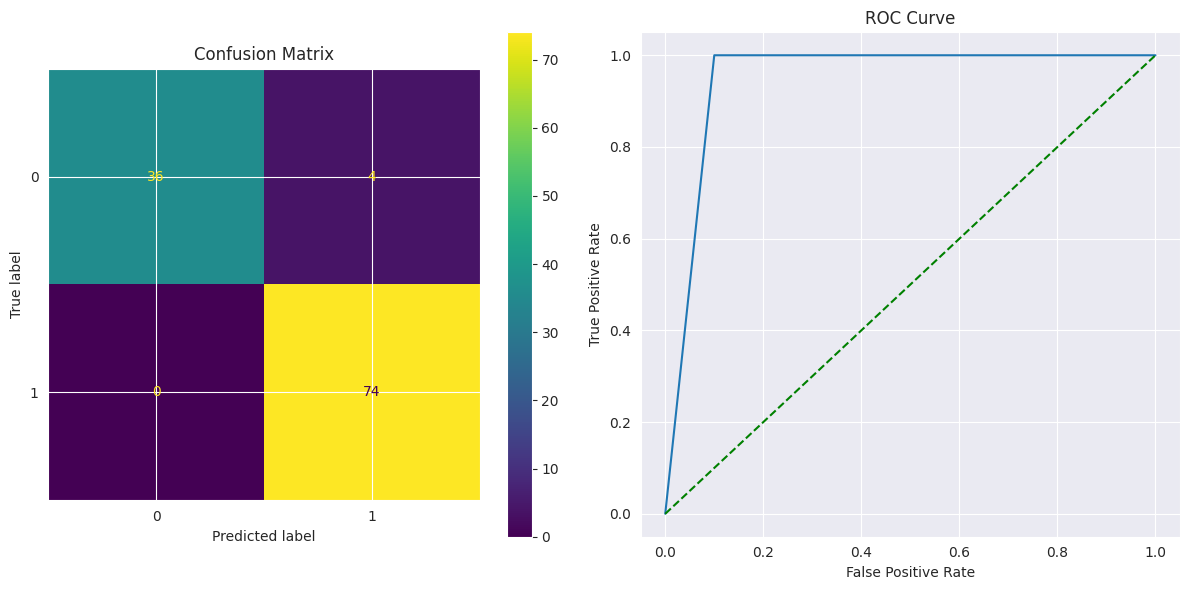

In [45]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(data.drop('diagnosis', axis=1), data['diagnosis'], test_size=.2, random_state=41)


gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

generate_results(y_test, y_pred_gnb)

Categorial Naive Bayes with sklearn library

Accuracy: 0.9385964912280702
Precision: 0.971830985915493
Recall: 0.9324324324324325
F1 Score: 0.9517241379310345

AUC: 0.9412162162162161

Log loss: 2.2132067870510532



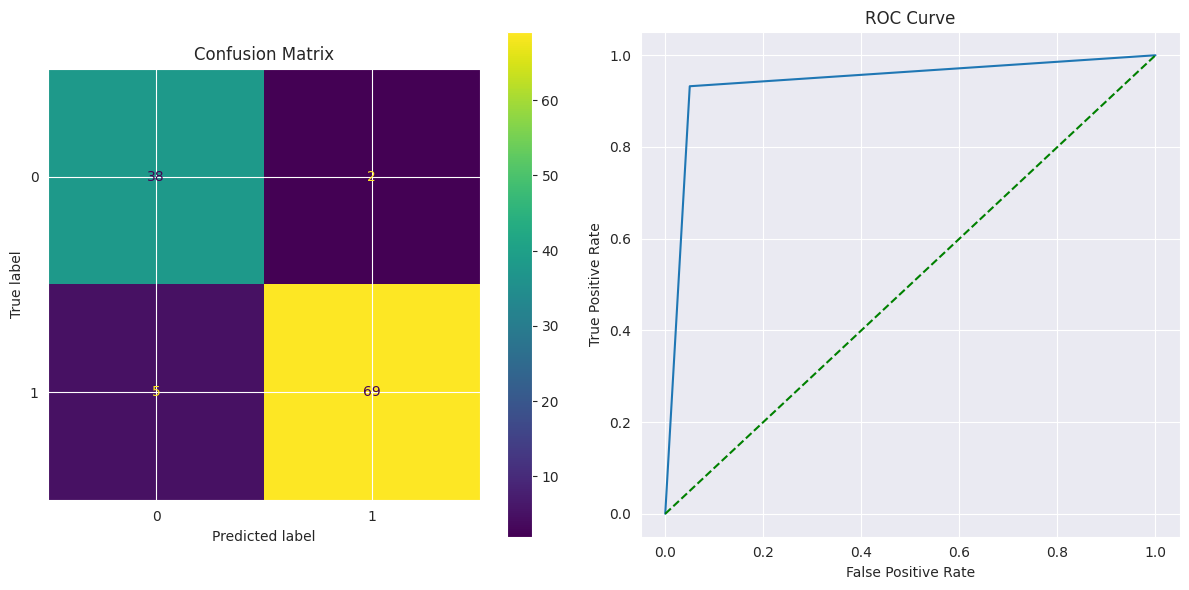

In [46]:
from sklearn.naive_bayes import CategoricalNB

X_train, X_test, y_train, y_test = train_test_split(data_encoded.drop('diagnosis', axis=1), data_encoded['diagnosis'], test_size=.2, random_state=41)

cat_nb = CategoricalNB()
cat_nb.fit(X_train, y_train)
y_pred_cat = cat_nb.predict(X_test)

generate_results(y_test, y_pred_cat)

---

**Conclusion**



The results indicate a high level of consistency between the scratch implementation and the scikit-learn implementation for both Gaussian Naive Bayes and Categorical Naive Bayes.